In [1]:
import pandas
import konlpy
import gensim
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace = True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index : word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해본다.
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +4*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 :  15.96940191154864
문장 길이의 최대 :  116
문장 길이 표준 편차 :  12.843571191092
pad_sequences maxlen :  67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다.


In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                            value = word_to_index['<PAD>'],
                            padding = 'post', maxlen = maxlen)
print(x_train.shape)

(146182, 67)


In [8]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 15 # 워드 벡터의 차원수

In [9]:
# 모델 설계. 위에서 만든 모델을 사용해봅시다.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 15)          150000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1696      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [10]:
# validation set 10000건 분리
x_val = x_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


In [11]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 20

history = model.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.5084 - accuracy: 0.7420 - val_loss: 0.3459 - val_accuracy: 0.8486
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3216 - accuracy: 0.8623 - val_loss: 0.3289 - val_accuracy: 0.8549
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2891 - accuracy: 0.8795 - val_loss: 0.3251 - val_accuracy: 0.8562
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2651 - accuracy: 0.8913 - val_loss: 0.3305 - val_accuracy: 0.8565
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2420 - accuracy: 0.9023 - val_loss: 0.3386 - val_accuracy: 0.8553
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2169 - accuracy: 0.9148 - val_loss: 0.3579 - val_accuracy: 0.8514
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1943 - accuracy: 0.9260 - val_loss: 0.3759 - val_accuracy: 0.8514
Epoch 

In [12]:
results = model.evaluate(x_test, y_test, verbose = 2)

print(results)

1537/1537 - 3s - loss: 0.9565 - accuracy: 0.8228
[0.9564872980117798, 0.8227719068527222]


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


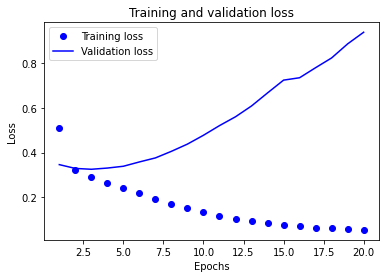

In [14]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

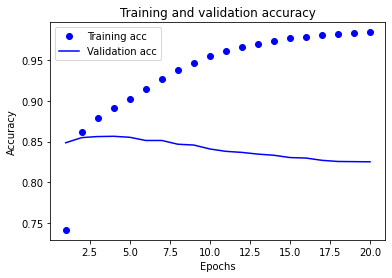

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()